In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds

Positive reviews are 25000 and negative reviews are 25000 of total 50000 


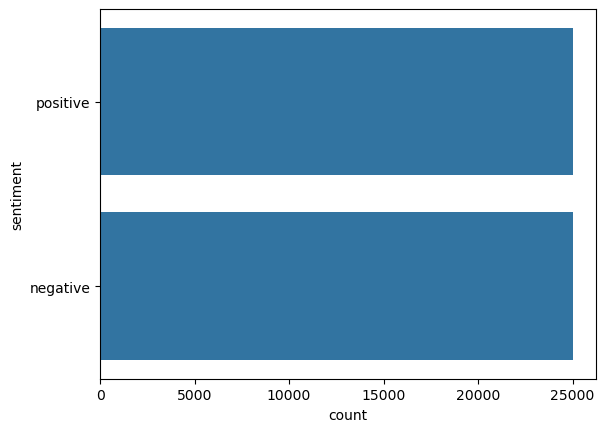

In [40]:
dataset = pd.read_csv('IMDB Dataset.csv')
negative = len(dataset[dataset['sentiment']=='negative'])
positive = len(dataset) - negative
sns.countplot(dataset['sentiment'])
print('Positive reviews are {} and negative reviews are {} of total {} '.format(positive,negative,len(dataset)))

Converting the labels positve and negative as 1,0 so that they can be fed to the neural network to predict whether the given review is a positive or negative. Splitting of data 80% for the training and remaining 20% for testing.

In [43]:
le = LabelEncoder()
training_reviews,testing_reviews,training_labels,testing_labels  = train_test_split(dataset['review'].values,dataset['sentiment'].values,test_size = 0.2)
training_labels = le.fit_transform(training_labels)
testing_labels = le.fit_transform(testing_labels)

Pre-Processing
Using tokenizer to produce token for a given word and taking maximum length of 200 character of a review and after we simply truncate the input review and then padded the input to max len of 200. 

In [46]:
tokenizer = Tokenizer(num_words=10000,oov_token='<OOV>')
tokenizer.fit_on_texts(training_reviews)
word_index = tokenizer.word_index
training_sequence = tokenizer.texts_to_sequences(training_reviews)
testing_sequence = tokenizer.texts_to_sequences(testing_reviews)
train_pad_sequence = pad_sequences(training_sequence,maxlen = 200,truncating= 'post',padding = 'pre')
test_pad_sequence = pad_sequences(testing_sequence,maxlen = 200,truncating= 'post',padding = 'pre')
print('Total Unique Words : {}'.format(len(word_index)))

Total Unique Words : 112332


Using glove vectors for embedding

In [52]:
embedded_words = {}
with open('glove.6B.100d.txt') as file:
    for line in file:
        words, coeff = line.split(maxsplit=1)
        coeff = np.array(coeff.split(),dtype = float)
        embedded_words[words] = coeff

In [56]:
embedding_matrix = np.zeros((len(word_index) + 1,100))
for word, i in word_index.items():
    embedding_vector = embedded_words.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


layer1: Embedding Layer using glove weights 

layer2: Using a Bidirectional LSTM

layer3: A dropout Layer

layer4: A Dense layer of 256 neurons with 'relu' activation

layer5: A Dense Layer of 128 neurons with 'relu' activation

layer6: Again a dropout layer. 

layer7: Sigmoid activation layer to classify it positive and negative.


In [61]:
model = tf.keras.Sequential([tf.keras.layers.Embedding(len(word_index) + 1,100,weights=[embedding_matrix],input_length=200,
                            trainable=False),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(256,activation = 'relu',),
                             tf.keras.layers.Dense(128,activation = 'relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1,activation = tf.nn.sigmoid)])

/home/comp-sys-6/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [63]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │    11,233,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,233,300 (42.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 11,233,300 (42.85 MB)

In [65]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy() , optimizer='Adam' , metrics = ['accuracy'])
history = model.fit(train_pad_sequence,training_labels,epochs = 30 ,validation_data=(test_pad_sequence,testing_labels))

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - accuracy: 0.6399 - loss: 0.6124 - val_accuracy: 0.8129 - val_loss: 0.4147
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.8212 - loss: 0.4061 - val_accuracy: 0.8407 - val_loss: 0.3715
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.8426 - loss: 0.3623 - val_accuracy: 0.8477 - val_loss: 0.3458
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 28ms/step - accuracy: 0.8527 - loss: 0.3391 - val_accuracy: 0.8519 - val_loss: 0.3314
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 28ms/step - accuracy: 0.8674 - loss: 0.3177 - val_accuracy: 0.8615 - val_loss: 0.3219
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 28ms/step - accuracy: 0.8764 - loss: 0.2966 - val_accuracy: 0.8571 - val_loss: 0.3293
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - accuracy: 0.8797 - loss: 0.2899 - val_accuracy: 0.8599 - val_loss: 0.3223
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.8875 -

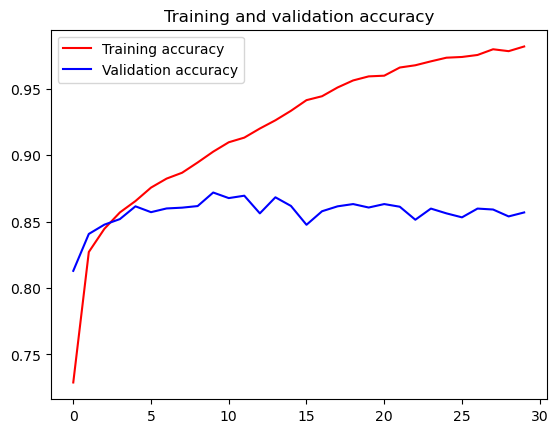

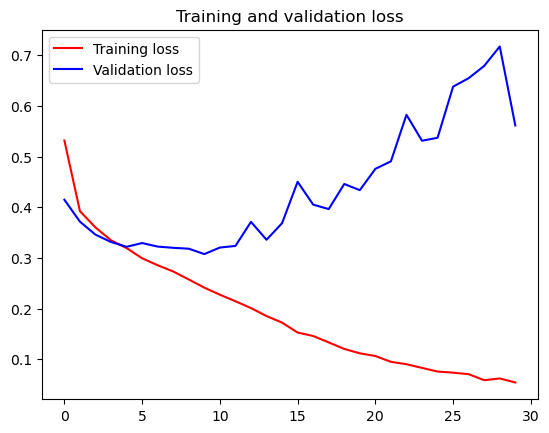

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [70]:
print('Training Accuracy: {}'.format(max(acc)))
print('Validation Accuracy: {}'.format(max(val_acc)))

Training Accuracy: 0.9818999767303467
Validation Accuracy: 0.8719000220298767


In [88]:
def classify_review(review_text):
    seq = tokenizer.texts_to_sequences([review_text])
    padded = pad_sequences(seq, maxlen=200, truncating='post', padding='pre')
    prediction = model.predict(padded)[0][0]
    sentiment = 'Positive' if prediction >= 0.5 else 'Negative'
    print(f"Review: {review_text}\nSentiment: {sentiment}")

In [90]:
classify_review("The plot was boring and the acting was terrible.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Review: The plot was boring and the acting was terrible.
Sentiment: Negative
